In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from reedsolo import RSCodec, ReedSolomonError

In [2]:
DECODER_INPUT_SHAPE = (28, 28, 1)
BIT_COUNT = 16

## 設定要藏入的字串，可以自己設定

In [3]:
my_code = "hello world"
print(my_code.encode())

b'hello world'


## 將字串轉利用REED-Solomon經過編碼

In [4]:
rsc = RSCodec(151)  # 10 ecc symbols
my_code_encoded = rsc.encode(my_code.encode())
print(my_code_encoded)


bytearray(b'hello worldW\x9aH8\x94\xbaU\x14\x1cz\xea\x8d)\xc0\xe3\xa4Ox<?\xf3c\x05\x08\xc4\xe3\xf0!>L-\xc1\xca\xea\x99s\xdc\xa0\xb6\xee\x83\x8ah,\xbf\xcd\x1e\xec(\xbd^aQ\xd4\xc95\xa9B\xc2\xd7IY\xa1\xd5Ry5Q\x05Dt\xa4e\x93"\x98I\x9a\xe6\x979\xc0\x8cc\xd0\xcf\xa2\x05A\xa0\xe3j\xe4\x95H\x8ag\x88}\x18@\n\xb1\x12,\x8b\xe6\x8cb\xe9\xb5\xf1b\x02\xf1`\xd3\xdf\x96:\xfb\xf6\xdb\xec\x8coHk\x03m\xfb\x12\xd0K\xa4,\xff\x9a\xeb\xbf\x9adPR\xd9\x01\x97)\x02\x96\xd2')


In [5]:
#轉成16進制
my_code_encoded_hex = ''.join('{:02x}'.format(x) for x in my_code_encoded)
print(my_code_encoded_hex)
print("length:")
print(len(my_code_encoded_hex))

68656c6c6f20776f726c64579a483894ba55141c7aea8d29c0e3a44f783c3ff3630508c4e3f0213e4c2dc1caea9973dca0b6ee838a682cbfcd1eec28bd5e6151d4c935a942c2d74959a1d552793551054474a465932298499ae69739c08c63d0cfa20541a0e36ae495488a67887d18400ab1122c8be68c62e9b5f16202f160d3df963afbf6dbec8c6f486b036dfb12d04ba42cff9aebbf9a645052d90197290296d2
length:
324


In [6]:
#用這個方法可以轉回byte array
my_code_encoded_revive = bytearray.fromhex(my_code_encoded_hex)
print(my_code_encoded_revive)

bytearray(b'hello worldW\x9aH8\x94\xbaU\x14\x1cz\xea\x8d)\xc0\xe3\xa4Ox<?\xf3c\x05\x08\xc4\xe3\xf0!>L-\xc1\xca\xea\x99s\xdc\xa0\xb6\xee\x83\x8ah,\xbf\xcd\x1e\xec(\xbd^aQ\xd4\xc95\xa9B\xc2\xd7IY\xa1\xd5Ry5Q\x05Dt\xa4e\x93"\x98I\x9a\xe6\x979\xc0\x8cc\xd0\xcf\xa2\x05A\xa0\xe3j\xe4\x95H\x8ag\x88}\x18@\n\xb1\x12,\x8b\xe6\x8cb\xe9\xb5\xf1b\x02\xf1`\xd3\xdf\x96:\xfb\xf6\xdb\xec\x8coHk\x03m\xfb\x12\xd0K\xa4,\xff\x9a\xeb\xbf\x9adPR\xd9\x01\x97)\x02\x96\xd2')


## 把照片讀入，並且轉成灰階

In [7]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

(504, 504)
[[0.38888157 0.36143333 0.34182745 ... 0.54178235 0.58402118 0.58402118]
 [0.40456627 0.3496698  0.2830098  ... 0.44375294 0.45854353 0.43893765]
 [0.41330275 0.33487922 0.24469216 ... 0.31043294 0.27816941 0.28601176]
 ...
 [0.43578157 0.41617569 0.37696392 ... 0.26338392 0.24769922 0.24769922]
 [0.40720353 0.36799176 0.29741059 ... 0.2133451  0.19766039 0.20158157]
 [0.41112471 0.37191294 0.29741059 ... 0.21726627 0.20550275 0.20550275]]


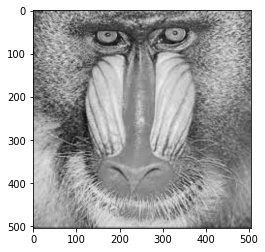

In [8]:
image = plt.imread('images/baboon.jpg')

image = rgb2gray(image)
image = image/255.0
print(image.shape)
plt.imshow(image, cmap='gray')
print(image)

## 把照片切成很多28*28的小照片

In [9]:
segmented_images = np.zeros((int(image.shape[0]/DECODER_INPUT_SHAPE[0]), int(image.shape[1]/DECODER_INPUT_SHAPE[0]), 28, 28))
print(segmented_images.shape)

(18, 18, 28, 28)


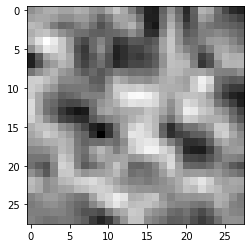

In [10]:
for i in range(segmented_images.shape[0]):
    for j in range(segmented_images.shape[1]):
        segmented_images[i,j,:,:] = image[i*28:(i+1)*28, j*28:(j+1)*28]

plt.imshow(segmented_images[0,2], cmap='gray')

(324, 28, 28)


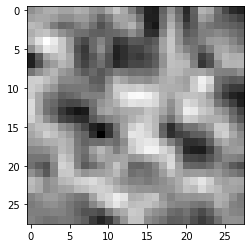

In [11]:
image_dataset = segmented_images.reshape(324,28,28)
print(image_dataset.shape)
plt.imshow(image_dataset[2], cmap='gray')

In [12]:
dataset_adv = [image_dataset.copy() for i in range(BIT_COUNT+1)]  #把照片拆成多組dataset

## 引入Model

In [13]:
decoder = tf.keras.models.load_model('models/decoder_one_hot_4_bit_costum_data_mean_filter.h5')

In [14]:
iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍

#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new  = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new , x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

## 生成onehot encoding


In [15]:
list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 嵌入浮水印

In [16]:
for _ in range(30):
    for i in range(1, BIT_COUNT+1):
        dataset_adv[i] = pgd_attack_to_target(dataset_adv[i], [user_code[i]] * len(dataset_adv[i]),
                                             tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon, alpha,
                                             iterations)

In [17]:
for i in range(BIT_COUNT+1):
    decoder.evaluate(dataset_adv[i], np.array([user_code[i]] * len(dataset_adv[i])))

11/11 [==============================] - 0s 5ms/step - loss: 0.0015 - categorical_accuracy: 0.9969


## 把圖片組合起來

In [18]:
final_picture = np.ones((28*18, 28*18))

In [19]:
for index in range(len(my_code_encoded_hex)):
    x = int(index/18)
    y = int(index%18)
    final_picture[28*x : 28*(x+1) , 28*y : 28*(y+1)] = dataset_adv[int(my_code_encoded_hex[index],16)+1][index]

## 放入資訊的圖片

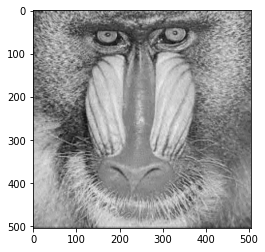

In [20]:
plt.imshow(final_picture,cmap='gray')

## 解讀圖片

In [21]:
def decode_image(image):
    decodedString = ""
    for index in range(324):
        # if(index>1):
        #     print("before index:",index,"strLength:",len(decodedString),"last:",decodedString[-1])
        x = int(index/18)
        y = int(index%18)
        decoded_num = np.argmax(decoder.predict(np.expand_dims(image[28*x : 28*(x+1) , 28*y : 28*(y+1)],axis=0)))-1
        if(decoded_num<0):
            decoded_num=0
        decoded = format(decoded_num, 'x')
        #print(decoded)
        decodedString += str(decoded)
        # print("after index:",index,"strLength:",len(decodedString),"num:",decoded_num,"added:",decoded)
    print("decoded string:",decodedString)
    #用這個方法可以轉回byte array
    decoded_revive = bytearray.fromhex(decodedString)
    print("decoded_revive:",decoded_revive)
    return rsc.decode(decoded_revive)[0].decode("utf-8")


In [22]:
print(decode_image(final_picture))

decoded string: 68656c6c6f20776f726c64579a483894ba55141c7aea8d29c0e3a44f783c3ff3630508c4e3f0213e4c2dc1caea9973dca0b6ee838a682cbfcd1eec28bd5e6151d4c935a942c2d74959a1d552793551054474a465932298499ae69739c08c63d0cfa20541a0e36ae495488a67887d18400ab1122c8be68c62e9b5f16202f160d3df963afbf6dbec8c6f486b036dfb12d04ba42cff9aebbf9a645052d90197290296d2
decoded_revive: bytearray(b'hello worldW\x9aH8\x94\xbaU\x14\x1cz\xea\x8d)\xc0\xe3\xa4Ox<?\xf3c\x05\x08\xc4\xe3\xf0!>L-\xc1\xca\xea\x99s\xdc\xa0\xb6\xee\x83\x8ah,\xbf\xcd\x1e\xec(\xbd^aQ\xd4\xc95\xa9B\xc2\xd7IY\xa1\xd5Ry5Q\x05Dt\xa4e\x93"\x98I\x9a\xe6\x979\xc0\x8cc\xd0\xcf\xa2\x05A\xa0\xe3j\xe4\x95H\x8ag\x88}\x18@\n\xb1\x12,\x8b\xe6\x8cb\xe9\xb5\xf1b\x02\xf1`\xd3\xdf\x96:\xfb\xf6\xdb\xec\x8coHk\x03m\xfb\x12\xd0K\xa4,\xff\x9a\xeb\xbf\x9adPR\xd9\x01\x97)\x02\x96\xd2')
hello world


## 挖洞

In [23]:
cut_more_image = final_picture.copy()
cut_more_image[28*3 : 28*(3+5) , 28*2 : 28*(2+1)] = 0
cut_more_image[28*3 : 28*(3+1) , 28*3 : 28*(3+7)] = 0
cut_more_image[28*4 : 28*(4+1) , 28*5 : 28*(5+3)] = 0
cut_more_image[28*8 : 28*(8+9) , 28*4 : 28*(4+7)] = 0
print(decode_image(cut_more_image))

decoded string: 68656c6c6f20776f726c64579a483894ba55141c7aea8d29c0e3a44f66666666630508c4e36026664c2dc1caea9963dca0b6ee838a682c6fcd1eec28bd5e615164c935a942c2d74959a16666666551054474a466666668499ae6973966666660cfa20541a066666665488a67887d66666661122c8be68c666666616202f160d36666666bf6dbec8c6f6666666dfb12d04ba46666666bbf9a645052d90197290296d2
decoded_revive: bytearray(b'hello worldW\x9aH8\x94\xbaU\x14\x1cz\xea\x8d)\xc0\xe3\xa4Offffc\x05\x08\xc4\xe3`&fL-\xc1\xca\xea\x99c\xdc\xa0\xb6\xee\x83\x8ah,o\xcd\x1e\xec(\xbd^aQd\xc95\xa9B\xc2\xd7IY\xa1fffeQ\x05Dt\xa4fffhI\x9a\xe6\x979fff`\xcf\xa2\x05A\xa0fffeH\x8ag\x88}fffa\x12,\x8b\xe6\x8cfffab\x02\xf1`\xd3fffk\xf6\xdb\xec\x8cofffm\xfb\x12\xd0K\xa4fffk\xbf\x9adPR\xd9\x01\x97)\x02\x96\xd2')
hello world


## 加噪點(Salt&Pepper)

In [24]:
from skimage import io,util
noise_image = final_picture.copy()
noise_image = util.noise.random_noise(noise_image,mode ='s&p',amount = 0.010)
print(decode_image(noise_image))

decoded string: 68656c6c6f20876fb26c64b49af83298ea50141c7a8a4d2950e3a4ff783c3ff3600508c4e3f0213e4cadcec1ea997bd5a0b31e838a682cb0cd1eec28bd5e615ed45937a542c2d74659a1d57279355135d474a465908298169ae0503cc0bc63d06fd005e1aae360e4f2488a677e9d18403ab1122c8be68c60e9b5916202f16ed3df903afbfadb8c8a0f426b036dfb12f04ba42cff9ab0bf9af45b52d93197270296d2
decoded_revive: bytearray(b"hello \x87o\xb2ld\xb4\x9a\xf82\x98\xeaP\x14\x1cz\x8aM)P\xe3\xa4\xffx<?\xf3`\x05\x08\xc4\xe3\xf0!>L\xad\xce\xc1\xea\x99{\xd5\xa0\xb3\x1e\x83\x8ah,\xb0\xcd\x1e\xec(\xbd^a^\xd4Y7\xa5B\xc2\xd7FY\xa1\xd5ry5Q5\xd4t\xa4e\x90\x82\x98\x16\x9a\xe0P<\xc0\xbcc\xd0o\xd0\x05\xe1\xaa\xe3`\xe4\xf2H\x8ag~\x9d\x18@:\xb1\x12,\x8b\xe6\x8c`\xe9\xb5\x91b\x02\xf1n\xd3\xdf\x90:\xfb\xfa\xdb\x8c\x8a\x0fBk\x03m\xfb\x12\xf0K\xa4,\xff\x9a\xb0\xbf\x9a\xf4[R\xd91\x97\'\x02\x96\xd2")
hello world


## 模糊(平均濾波)

In [25]:
from scipy import ndimage
mean_filter_image = final_picture.copy()
print(mean_filter_image.shape)
kernel = np.ones((3,3)) / 9.0
mean_filter_image = ndimage.convolve(mean_filter_image, kernel, mode='constant', cval=0.0)
print(decode_image(mean_filter_image))

(504, 504)
decoded string: 686b6c6c0f20776f026c64589af8c8940a55141c7aea8d29c0e0a84f783c3ff3630508c4e3f0213e4c2dc1caea99730ca0b6ee838a682cb6cd1eec28bd5e6151d4c935a942c2d74959a1d552793551054474a465932298499ae69739c08c63d0cfa20501a0e36ae495488a67887d18400ab1122c8be68c62e9b5f16202f160d30f963afbf6dbec8c6f486b036dfb12d04ba02cff9aebbf9a645052d90197290296d2
decoded_revive: bytearray(b'hkll\x0f wo\x02ldX\x9a\xf8\xc8\x94\nU\x14\x1cz\xea\x8d)\xc0\xe0\xa8Ox<?\xf3c\x05\x08\xc4\xe3\xf0!>L-\xc1\xca\xea\x99s\x0c\xa0\xb6\xee\x83\x8ah,\xb6\xcd\x1e\xec(\xbd^aQ\xd4\xc95\xa9B\xc2\xd7IY\xa1\xd5Ry5Q\x05Dt\xa4e\x93"\x98I\x9a\xe6\x979\xc0\x8cc\xd0\xcf\xa2\x05\x01\xa0\xe3j\xe4\x95H\x8ag\x88}\x18@\n\xb1\x12,\x8b\xe6\x8cb\xe9\xb5\xf1b\x02\xf1`\xd3\x0f\x96:\xfb\xf6\xdb\xec\x8coHk\x03m\xfb\x12\xd0K\xa0,\xff\x9a\xeb\xbf\x9adPR\xd9\x01\x97)\x02\x96\xd2')
hello world


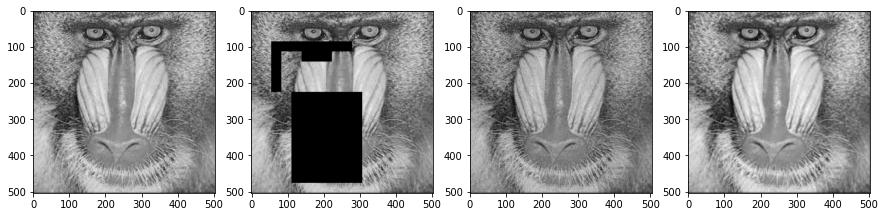

In [31]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(final_picture,cmap='gray')
plt.subplot(1,4,2)
plt.imshow(cut_more_image,cmap='gray')
plt.subplot(1,4,3)
plt.imshow(noise_image,cmap='gray')
plt.subplot(1,4,4)
plt.imshow(mean_filter_image,cmap='gray')